# ConSBind Tutorial - Programmatic Usage

This notebook demonstrates how to use the ConSBind package programmatically for predicting protein binding sites,
with enhanced visualizations and analysis.

## Overview

ConSBind (Consensus Structural Binding site predictor) identifies potential binding sites in protein structures
using a consensus of geometric and energy-based approaches. This tutorial shows how to:

1. Load protein structures
2. Run binding site predictions
3. Access and analyze prediction results
4. Visualize binding sites with advanced plots
5. Compare different scoring methods
6. Analyze pocket properties

Let's get started!

## Setup

First, let's import the necessary modules and set up logging.

In [2]:
import os
import sys
import logging
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image, display
from Bio.PDB import PDBParser, Selection

# Import ConSBind modules
from ConSBind.input.file_handler import convert_ent_to_pdb, find_pdb_files
from ConSBind.core.structure import ProteinStructure
from ConSBind.core.finder import ConsensusPocketFinder
from ConSBind.core.scoring import final_scoring
from ConSBind.output.output import save_predictions, save_pymol, save_chimera

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('ConSBind-Tutorial')

## Load Protein Structure

First, we'll load a protein structure from a PDB file. ConSBind requires a valid PDB file as input.
If you don't have a PDB file handy, you can download one from the Protein Data Bank using BioPython's PDBList module.

For this tutorial, we'll downlod HIV-1 protease with indinavir (`1HSG`):

In [6]:
import Bio.PDB.PDBList
pdblist = Bio.PDB.PDBList()
pdb_id = "1hsg" 
os.makedirs("data/tutorial", exist_ok=True)

print(f"Downloading PDB ID: {pdb_id} in PDB format...")
pdblist.retrieve_pdb_file(pdb_id, file_format="pdb", pdir="data/tutorial")
    
# PDBList downloads files with .ent extension
ent_file = Path(f"data/tutorial/pdb{pdb_id}.ent")
    
print(f"Downloaded PDB file to {ent_file}")

# Convert .ent to .pdb using ConSBind's file handler
pdb_file = str(convert_ent_to_pdb(ent_file))
print(f"Converted to PDB format: {pdb_file}")

2025-03-25 19:48:56,083 - ConSBind - INFO - Converting .ent file to .pdb format: pdb1hsg.ent
2025-03-25 19:48:56,092 - ConSBind - INFO - Converted to: pdb1hsg.pdb


Downloaded PDB file to data/tutorial/pdb1hsg.ent
Converted to PDB format: /var/folders/jh/bm1wh6mn3ms2596tlzslwrdw0000gn/T/consbind_temp/pdb1hsg.pdb


Now that we have a PDB file, we can load it using ConSBind's ProteinStructure class.
This class handles parsing the PDB file and preparing it for binding site prediction.

In [7]:
try:
    print(f"Loading protein structure from {pdb_file}...")
    protein = ProteinStructure(pdb_file)
    print("Protein structure loaded successfully!")
    
except Exception as e:
    print(f"Error loading protein structure: {str(e)}")
    sys.exit(1)

Loading protein structure from /var/folders/jh/bm1wh6mn3ms2596tlzslwrdw0000gn/T/consbind_temp/pdb1hsg.pdb...
Protein structure loaded successfully!
Protein ID: pdb1hsg
Number of chains: 2
Number of residues: 326
Number of atoms: 1686


## Protein Structure Analysis

Before predicting binding sites, let's analyze the protein structure to understand its properties.


Protein ID: pdb1hsg
Number of chains: 2
Number of residues: 326
Number of atoms: 1686


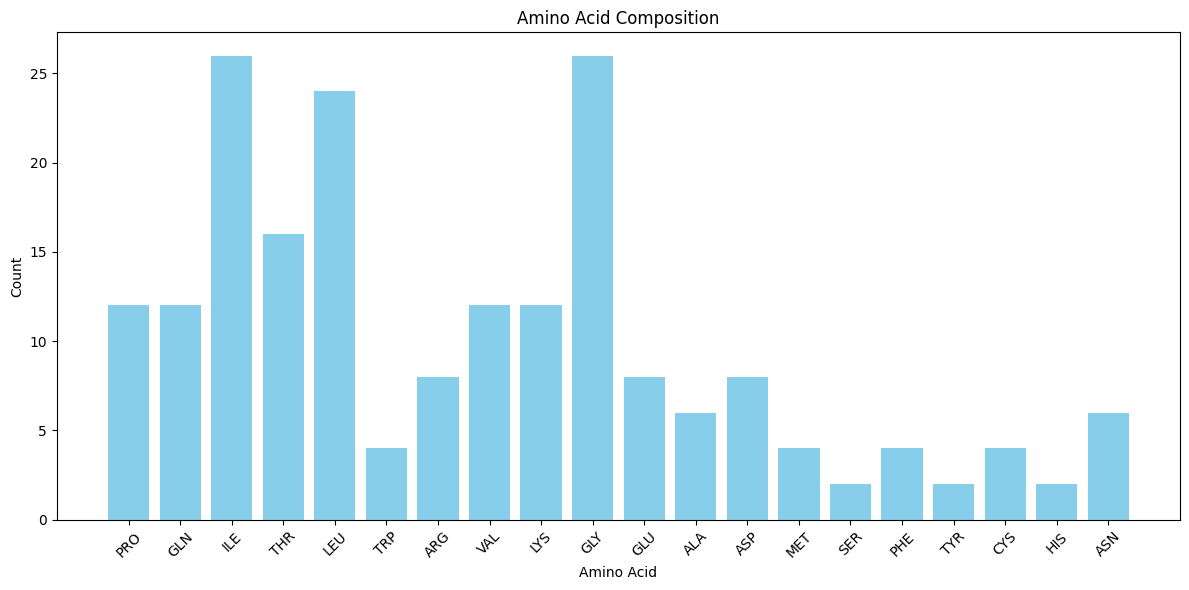

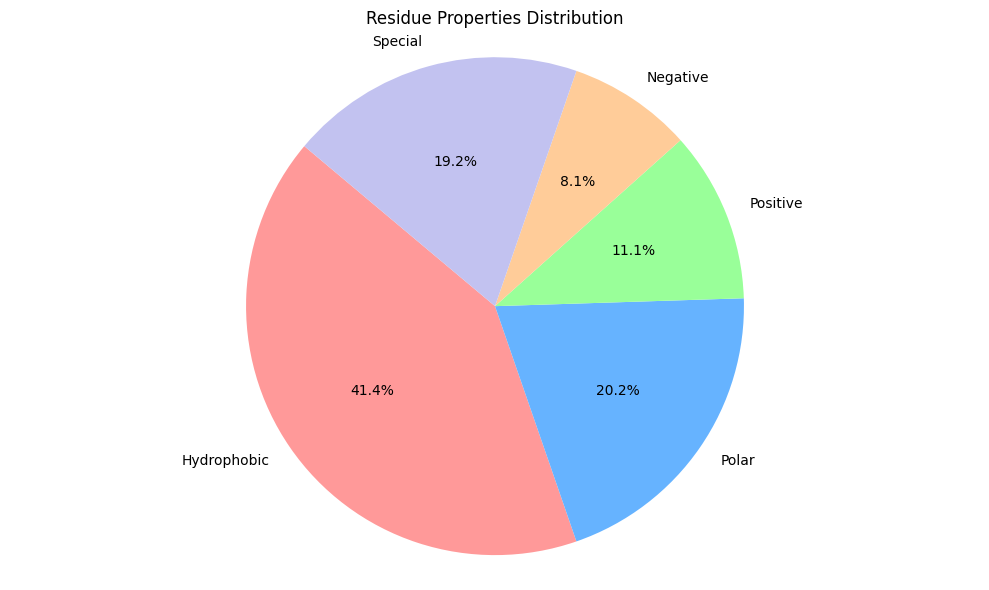

In [11]:
def analyze_protein_structure(protein):
    """
    Analyze and visualize protein structure properties
    """
    # Get basic protein information
    structure = protein.structure
    chains = list(structure.get_chains())
    residues = list(structure.get_residues())
    atoms = list(structure.get_atoms())
    
    print(f"Protein ID: {protein.pdb_id}")
    print(f"Number of chains: {len(chains)}")
    print(f"Number of residues: {len(residues)}")
    print(f"Number of atoms: {len(atoms)}")
    
    # Analyze residue composition
    residue_types = {}
    for residue in residues:
        res_name = residue.get_resname()
        if res_name in residue_types:
            residue_types[res_name] += 1
        else:
            residue_types[res_name] = 1
    
    # Exclude non-standard residues
    standard_residues = {
        'ALA': 'Alanine', 'ARG': 'Arginine', 'ASN': 'Asparagine', 
        'ASP': 'Aspartic acid', 'CYS': 'Cysteine', 'GLN': 'Glutamine', 
        'GLU': 'Glutamic acid', 'GLY': 'Glycine', 'HIS': 'Histidine', 
        'ILE': 'Isoleucine', 'LEU': 'Leucine', 'LYS': 'Lysine', 
        'MET': 'Methionine', 'PHE': 'Phenylalanine', 'PRO': 'Proline', 
        'SER': 'Serine', 'THR': 'Threonine', 'TRP': 'Tryptophan', 
        'TYR': 'Tyrosine', 'VAL': 'Valine'
    }
    
    # Filter for standard residues
    std_residue_counts = {k: v for k, v in residue_types.items() if k in standard_residues}
    
    # Plot residue composition
    plt.figure(figsize=(12, 6))
    plt.bar(std_residue_counts.keys(), std_residue_counts.values(), color='skyblue')
    plt.title('Amino Acid Composition')
    plt.xlabel('Amino Acid')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Categorize residues by property
    hydrophobic = ['ALA', 'VAL', 'ILE', 'LEU', 'MET', 'PHE', 'TYR', 'TRP']
    polar = ['SER', 'THR', 'ASN', 'GLN', 'CYS']
    charged_positive = ['LYS', 'ARG', 'HIS']
    charged_negative = ['ASP', 'GLU']
    special = ['GLY', 'PRO']
    
    categories = {
        'Hydrophobic': sum(std_residue_counts.get(aa, 0) for aa in hydrophobic),
        'Polar': sum(std_residue_counts.get(aa, 0) for aa in polar),
        'Positive': sum(std_residue_counts.get(aa, 0) for aa in charged_positive),
        'Negative': sum(std_residue_counts.get(aa, 0) for aa in charged_negative),
        'Special': sum(std_residue_counts.get(aa, 0) for aa in special)
    }
    
    # Plot residue categories
    plt.figure(figsize=(10, 6))
    plt.pie(categories.values(), labels=categories.keys(), autopct='%1.1f%%', 
            startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
    plt.axis('equal')
    plt.title('Residue Properties Distribution')
    plt.tight_layout()
    plt.show()
    
    return residue_types

# Analyze the protein structure
residue_composition = analyze_protein_structure(protein)

## Creating a Binding Site Prediction Function

Next, let's define a function to predict binding sites:

In [38]:

def predict_binding_sites(protein, protein_type='enzyme', probe_radius=1.4, min_size=5):
    """
    Predict binding sites for a protein structure.
    """
    print(f"Predicting binding sites for {protein.pdb_id}...")
    
    # Create a pocket finder
    finder = ConsensusPocketFinder()
    
    # Find pockets using geometric method
    geometric_pockets = finder.find_pockets_geometric(protein, probe_radius=probe_radius, min_size=min_size)
    print(f"Found {len(geometric_pockets)} pockets using geometric method")
    
    # Find pockets using energy-based method
    energy_pockets = finder.find_pockets_energy(protein)
    print(f"Found {len(energy_pockets)} pockets using energy-based method")
    
    # Combine pockets from different methods
    consensus_pockets = finder.combine_pockets(protein, geometric_pockets, energy_pockets)
    print(f"Combined into {len(consensus_pockets)} consensus pockets")
    
    # Apply final scoring and filtering
    final_pockets = final_scoring(consensus_pockets, protein_type)
    print(f"Final selection: {len(final_pockets)} significant pockets")
    
    return final_pockets

# Run the prediction
pockets = predict_binding_sites(protein, protein_type='enzyme')


2025-03-25 20:51:00,902 - ConSBind - INFO - Created grid with dimensions: 58x81x75


Predicting binding sites for pdb1hsg...


2025-03-25 20:51:02,065 - ConSBind - INFO - Found 492 potential cavity points
2025-03-25 20:51:02,082 - ConSBind - INFO - Found 22 cavities after clustering
2025-03-25 20:51:02,084 - ConSBind - INFO - Identified 806 surface atoms
2025-03-25 20:51:02,084 - ConSBind - INFO - Calculating energy scores for grid points...


Found 22 pockets using geometric method


2025-03-25 20:51:11,312 - ConSBind - INFO - Found 91 high-energy points
2025-03-25 20:51:11,316 - ConSBind - INFO - Found 7 energy-based pockets after clustering
2025-03-25 20:51:11,381 - ConSBind - INFO - Combined into 24 consensus pockets
2025-03-25 20:51:11,382 - ConSBind - INFO - Automatic filtering identified 4 significant pockets out of 24 total
2025-03-25 20:51:11,382 - ConSBind - INFO - Final selection: 4 pockets with scores ranging from 17.28 to 10.91


Found 7 pockets using energy-based method
Combined into 24 consensus pockets
Final selection: 4 significant pockets


## Visualizing Binding Site Predictions

Let's visualize the binding site predictions in various ways:

In [31]:
def display_binding_sites(pockets, protein):
    """
    Display detailed information about predicted binding sites.
    """
    if not pockets:
        print("No binding sites found.")
        return {}
    
    print("\n" + "="*60)
    print(" " * 18 + "PREDICTED BINDING SITES")
    print("="*60)
    
    site_data = {
        'site_id': [],
        'consensus_score': [],
        'final_score': [],
        'knowledge_score': [],
        'size': [],
        'center_x': [],
        'center_y': [],
        'center_z': [],
        'methods': [],
        'residue_count': []
    }
    
    for i, pocket in enumerate(pockets):
        print(f"\nBinding Site {i+1} Details:")
        print("-" * 60 + "\n")
        
        # Extract scores
        binding_score = pocket.get('final_score', 0)
        consensus_score = pocket.get('consensus_score', 0)
        knowledge_score = pocket.get('knowledge_score', 0)
        
        print(f"Binding Potential Score: {binding_score:.2f}")
        print(f"Consensus Score: {consensus_score:.2f}")
        print(f"Knowledge-based Score: {knowledge_score:.2f}")
        
        # Extract size and center
        size = pocket.get('size', 0)
        center = pocket.get('center', [0, 0, 0])
        
        print(f"Size: {size}")
        print(f"Center: [{center[0]:.2f}, {center[1]:.2f}, {center[2]:.2f}]")
        
        # Extract detection methods
        methods = pocket.get('methods', [])
        print(f"Detection Methods: {', '.join(methods)}")
        
        # Extract residues
        residues = pocket.get('residues', [])
        print("\nBinding Site Residues:")
        for residue in residues:
            print(f"  {residue}")
        
        # Store data for visualization
        site_data['site_id'].append(i+1)
        site_data['consensus_score'].append(consensus_score)
        site_data['final_score'].append(binding_score)
        site_data['knowledge_score'].append(knowledge_score)
        site_data['size'].append(size)
        site_data['center_x'].append(center[0])
        site_data['center_y'].append(center[1])
        site_data['center_z'].append(center[2])
        site_data['methods'].append(', '.join(methods))
        site_data['residue_count'].append(len(residues))
    
    return site_data

# Display the binding site details
site_data = display_binding_sites(pockets, protein)

2025-03-25 20:44:58,176 - ConSBind - INFO - Created grid with dimensions: 58x81x75


Predicting binding sites for pdb1hsg...


2025-03-25 20:44:59,045 - ConSBind - INFO - Found 531 potential cavity points
2025-03-25 20:44:59,056 - ConSBind - INFO - Found 18 cavities after clustering
2025-03-25 20:44:59,058 - ConSBind - INFO - Identified 806 surface atoms
2025-03-25 20:44:59,059 - ConSBind - INFO - Calculating energy scores for grid points...


Found 18 pockets using geometric method


2025-03-25 20:45:08,485 - ConSBind - INFO - Found 91 high-energy points
2025-03-25 20:45:08,489 - ConSBind - INFO - Found 6 energy-based pockets after clustering
2025-03-25 20:45:08,549 - ConSBind - INFO - Combined into 23 consensus pockets
2025-03-25 20:45:08,552 - ConSBind - INFO - Automatic filtering identified 1 significant pockets out of 23 total
2025-03-25 20:45:08,557 - ConSBind - WARNING - Statistical filtering failed: list index out of range. Using all pockets.
2025-03-25 20:45:08,558 - ConSBind - INFO - Final selection: 1 pockets with scores ranging from 14.76 to 14.76


Found 6 pockets using energy-based method
Combined into 23 consensus pockets
Final selection: 1 significant pockets

                  PREDICTED BINDING SITES

Binding Site 1 Details:
------------------------------------------------------------

Binding Potential Score: 14.76
Consensus Score: 3.00
Knowledge-based Score: 1.50
Size: 45
Center: [14.05, 36.54, 12.94]
Detection Methods: geometric, energy

Binding Site Residues:
  A:ILE13
  A:ILE15
  A:ASP29
  A:ASP30
  A:THR31
  A:VAL32
  A:LEU33
  A:ILE62
  A:LEU63
  A:ILE64
  A:ILE66
  A:ALA71
  A:ILE72
  A:GLY73
  A:THR74
  A:VAL75
  A:LEU76
  A:ILE84
  A:ILE85
  A:GLY86
  A:ARG87
  A:ASN88
  A:LEU89
  A:LEU90
  A:THR91
  A:GLN92
  A:ILE93


## Saving Prediction Results

ConSBind can generate visualization scripts for both PyMOL and UCSF Chimera.
You can control which scripts are generated using the parameters.
Now, let's save the prediction results to files for further analysis and visualization:

In [39]:
def save_results(pockets, protein, output_dir="results/tutorial", generate_pymol=True, generate_chimera=True):
    """
    Save prediction results to files.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define output prefix
    output_prefix = os.path.join(output_dir, protein.pdb_id)
    
    # Save predictions to text and PDB files
    output_file, output_pdb = save_predictions(pockets, protein, output_prefix)
    
    pymol_script = None
    chimera_script = None
    
    if generate_pymol:
        pymol_script = save_pymol(pockets, protein, output_prefix, output_pdb)
    
    if generate_chimera:
        chimera_script = save_chimera(pockets, protein, output_prefix, output_pdb)
    
    return output_file, output_pdb, pymol_script, chimera_script

output_files = save_results(pockets, protein)

2025-03-25 20:51:11,414 - ConSBind - INFO - Predictions saved to results/tutorial/pdb1hsg_predictions.txt
2025-03-25 20:51:11,414 - ConSBind - INFO - Modified PDB saved to results/tutorial/pdb1hsg_predicted.pdb
2025-03-25 20:51:11,419 - ConSBind - INFO - PyMOL script saved to results/tutorial/pdb1hsg_pymol.pml
2025-03-25 20:51:11,421 - ConSBind - INFO - UCSF Chimera BILD file saved to results/tutorial/pdb1hsg_spheres.bild
2025-03-25 20:51:11,421 - ConSBind - INFO - UCSF Chimera script saved to results/tutorial/pdb1hsg_chimera.cmd


## Analyzing Residue Properties in Binding Sites

Let's analyze the properties of residues in the binding sites:

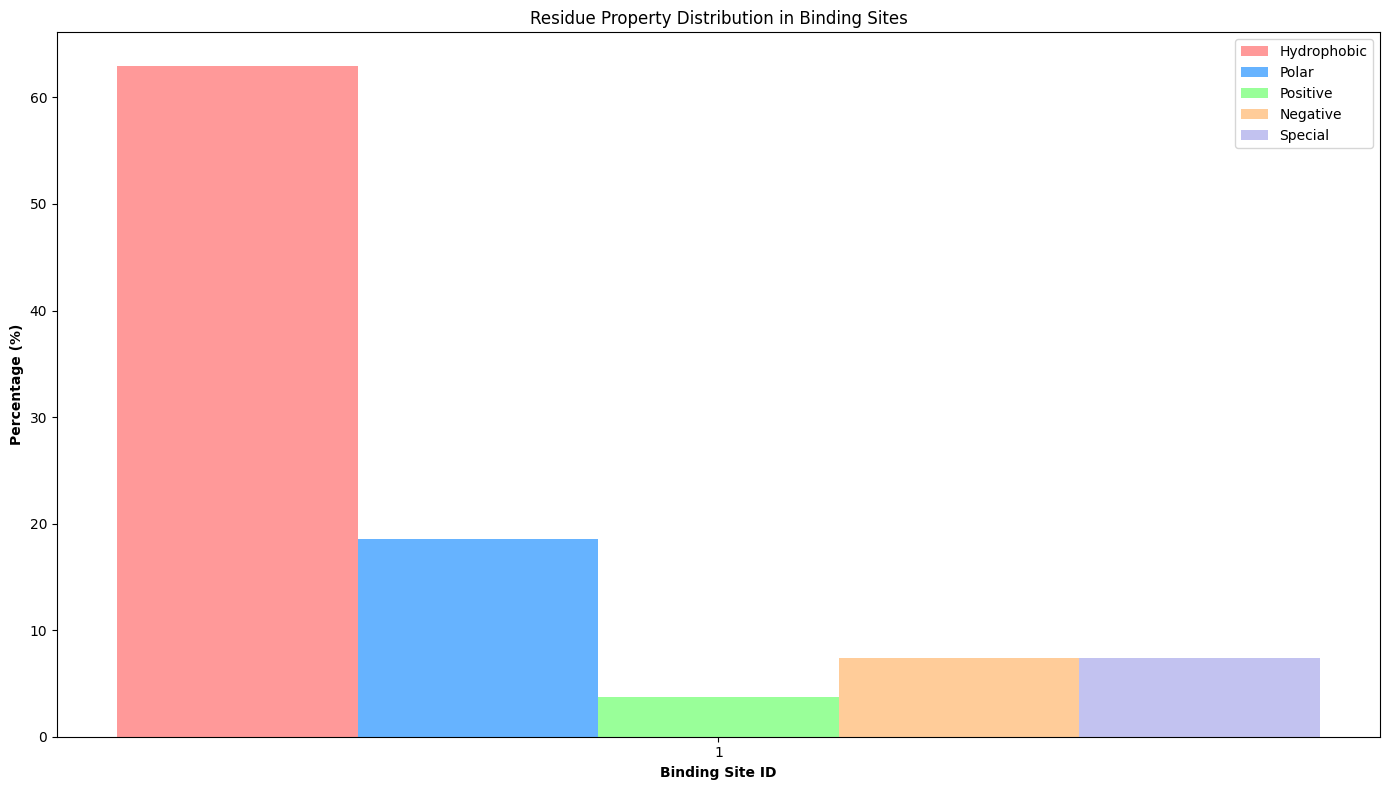

In [37]:
def analyze_binding_site_residues(pockets, protein):
    """
    Analyze the properties of residues in binding sites.
    
    Parameters:
    -----------
    pockets : list
        List of pocket dictionaries
    protein : ProteinStructure
        The protein structure
        
    Returns:
    --------
    dict
        Dictionary with residue analysis data
    """
    if not pockets:
        print("No binding sites to analyze.")
        return {}
    
    # Define residue property groups
    residue_properties = {
        'Hydrophobic': ['ALA', 'VAL', 'ILE', 'LEU', 'MET', 'PHE', 'TYR', 'TRP'],
        'Polar': ['SER', 'THR', 'ASN', 'GLN', 'CYS'],
        'Positive': ['LYS', 'ARG', 'HIS'],
        'Negative': ['ASP', 'GLU'],
        'Special': ['GLY', 'PRO']
    }
    
    # Initialize data structure
    analysis_data = {
        'site_id': [],
        'total_residues': [],
        'hydrophobic': [],
        'polar': [],
        'positive': [],
        'negative': [],
        'special': []
    }
    
    # Analyze each pocket
    for i, pocket in enumerate(pockets):
        residues = pocket.get('residues', [])
        
        # Count residues by property
        property_counts = {prop: 0 for prop in residue_properties}
        
        for residue_str in residues:
            # Extract residue name (format: "A:ALA123")
            parts = residue_str.split(':')
            if len(parts) == 2:
                res_name = parts[1][:3]  # First 3 characters are the residue name
                
                # Count by property
                for prop, res_list in residue_properties.items():
                    if res_name in res_list:
                        property_counts[prop] += 1
                        break
        
        # Store data
        analysis_data['site_id'].append(i+1)
        analysis_data['total_residues'].append(len(residues))
        analysis_data['hydrophobic'].append(property_counts['Hydrophobic'])
        analysis_data['polar'].append(property_counts['Polar'])
        analysis_data['positive'].append(property_counts['Positive'])
        analysis_data['negative'].append(property_counts['Negative'])
        analysis_data['special'].append(property_counts['Special'])
    
    # Create DataFrame
    df = pd.DataFrame(analysis_data)
    
    # Calculate percentages
    for prop in ['hydrophobic', 'polar', 'positive', 'negative', 'special']:
        df[f'{prop}_pct'] = df[prop] / df['total_residues'] * 100
    
    # Plot residue composition for each binding site
    plt.figure(figsize=(14, 8))
    
    # Set width of bars
    barWidth = 0.15
    
    # Set positions of bars on X axis
    r1 = np.arange(len(df['site_id']))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    
    # Create bars
    plt.bar(r1, df['hydrophobic_pct'], width=barWidth, label='Hydrophobic', color='#ff9999')
    plt.bar(r2, df['polar_pct'], width=barWidth, label='Polar', color='#66b3ff')
    plt.bar(r3, df['positive_pct'], width=barWidth, label='Positive', color='#99ff99')
    plt.bar(r4, df['negative_pct'], width=barWidth, label='Negative', color='#ffcc99')
    plt.bar(r5, df['special_pct'], width=barWidth, label='Special', color='#c2c2f0')
    
    # Add labels and title
    plt.xlabel('Binding Site ID', fontweight='bold')
    plt.ylabel('Percentage (%)', fontweight='bold')
    plt.title('Residue Property Distribution in Binding Sites')
    plt.xticks([r + barWidth*2 for r in range(len(df['site_id']))], df['site_id'])
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return df

# Analyze binding site residues
residue_analysis = analyze_binding_site_residues(pockets, protein)

## Command-Line Usage

ConSBind can also be used from the command line, which is useful for batch processing multiple proteins or integrating into automated workflows. Let's explore how to use the command-line interface:

```bash
# Basic usage with a single PDB file
consbind path/to/your/protein.pdb

# Specify protein type (improves prediction accuracy)
consbind path/to/your/protein.pdb --protein_type enzyme

# Process all PDB files in a directory
consbind path/to/pdb_directory/

# Customize output directory
consbind path/to/your/protein.pdb --output_dir my_results

# Adjust prediction parameters
consbind path/to/your/protein.pdb --min_size 3 --probe_radius 1.6 --grid_spacing 0.8

# Control visualization script generation
consbind path/to/your/protein.pdb --generate_chimera False
```

### Command-Line Arguments

Here's a summary of the available command-line arguments:

| Argument | Description | Default |
|----------|-------------|--------|
| `input_path` | Input PDB file or directory containing PDB files | (Required) |
| `--output_dir` | Output directory | results |
| `--generate_pymol` | Generate PyMOL visualization script | True |
| `--generate_chimera` | Generate UCSF Chimera visualization script | True |
| `--min_size` | Minimum pocket size | 5 |
| `--probe_radius` | Probe radius for cavity detection | 1.4 |
| `--grid_spacing` | Grid spacing for energy calculations | 1.0 |
| `--consensus_threshold` | Minimum consensus score for reliable pockets | 1.5 |
| `--protein_type` | Type of protein (enzyme, transporter, receptor, unknown) | unknown |

### Example: Batch Processing Multiple Proteins

Here's a practical example of how to use ConSBind to batch process multiple proteins:

```python
import os
import subprocess
from pathlib import Path

# Directory containing PDB files
pdb_dir = "data/multiple_proteins"
os.makedirs(pdb_dir, exist_ok=True)

# List of interesting proteins to analyze
proteins = [
    ("1HSG", "HIV-1 protease (enzyme)"),
    ("4DFR", "Dihydrofolate reductase (enzyme)"),
    ("3PTB", "Bovine trypsin (enzyme)"),
    ("1STP", "Streptavidin (receptor)")
]

# Download proteins if needed
for pdb_id, description in proteins:
    pdb_file = os.path.join(pdb_dir, f"{pdb_id}.pdb")
    if not os.path.exists(pdb_file):
        print(f"Downloading {pdb_id} - {description}")
        import Bio.PDB.PDBList
        pdblist = Bio.PDB.PDBList()
        pdblist.retrieve_pdb_file(pdb_id, file_format="pdb", pdir=pdb_dir)
        
        # Convert .ent to .pdb if needed
        ent_file = Path(f"{pdb_dir}/pdb{pdb_id.lower()}.ent")
        if ent_file.exists():
            from ConSBind.input.file_handler import convert_ent_to_pdb
            pdb_file = convert_ent_to_pdb(ent_file)
            print(f"Converted to PDB format: {pdb_file}")

# Run ConSBind on all proteins
output_dir = "results/multiple_comparison"
cmd = f"consbind {pdb_dir} --output_dir {output_dir} --generate_pymol --generate_chimera"
print(f"Running: {cmd}")
# In a real script, you would use:
# subprocess.run(cmd, shell=True, check=True)
print("This would process all PDB files in the directory with both PyMOL and Chimera visualization scripts")
```

## Visualizing Results with PyMOL and Chimera

ConSBind generates visualization scripts for both PyMOL and UCSF Chimera. Here's how to use them:

### PyMOL Visualization

The PyMOL script colors the predicted binding sites and displays them as surfaces:

```bash
# Open PyMOL and load the script
pymol results/4dfr/4dfr_pymol.pml
```

The script automatically:
1. Loads the protein structure
2. Creates a surface representation
3. Colors each binding site with a different color
4. Labels the binding sites
5. Sets up a clean visualization with transparent surfaces

### UCSF Chimera Visualization

The Chimera script provides an alternative visualization:

```bash
# Open Chimera with the PDB file and run the script
chimera results/4dfr/4dfr_predicted.pdb results/4dfr/4dfr_chimera.cmd
```

The script:
1. Loads the protein structure
2. Creates a surface representation
3. Colors binding sites with distinct colors
4. Labels residues in each binding site
5. Sets up camera angles for optimal viewing

### Interpreting Visualization Results

When examining the visualizations, look for:

1. **Pocket location**: Are the binding sites in biologically relevant locations?
2. **Pocket size**: Larger pockets often indicate more significant binding sites
3. **Residue composition**: Check if known catalytic or binding residues are included
4. **Surface properties**: Examine the electrostatic and hydrophobic properties of the pocket

## Conclusion

In this enhanced tutorial, we've demonstrated how to:

1. Load protein structures using ConSBind
2. Predict binding sites using consensus approaches
3. Analyze and visualize binding site properties
4. Save prediction results for external visualization
5. Compare properties across different binding sites
6. Set up a framework for multi-protein analysis
7. Use ConSBind from the command line
8. Process multiple proteins in batch mode
9. Visualize results with PyMOL and UCSF Chimera
10. Troubleshoot common issues

ConSBind provides a framework for binding site prediction that combines geometric and energy-based approaches, to achieve more reliable predictions than with these single methods alone. 
These techniques can be applied to your own protein structures to identify potential binding sites
for drug discovery, protein engineering, or functional analysis.